
<div class="usecase-title">Melbourne Social Trend Analysis</div>
<div class="usecase-authors">Author: Deepthi Reddy Thatipally</div>

<div class="usecase-level-skill">
  <div class="usecase-level">Level: Intermediate</div>
  <div class="usecase-skill">Skills: Python, Data Visualization</div>
</div>

<div class="usecase-duration">Duration: {90} minutes</div>
"""

<div class="usecase-scenario">
  <h2>Scenario</h2>
  <p>The City of Melbourne Social Indicators Survey (CoMSIS) has been conducted annually since 2018 to gather valuable insights into the health, well-being, safety, participation, and social connection of communities within the Melbourne Local Government Area. The survey is conducted through telephone and online channels, it supports the reporting of key municipal outcome indicators as outlined in the Council Plan 2021–2025. These indicators enable the council to assess the impact of existing initiatives and inform the planning of future programs. This use case focuses on analyzing multi-year CoMSIS data (2018–2023) to understand how community sentiment has evolved over time. By uncovering trends and highlighting both high- and low-performing indicators, the analysis provides evidence-based insights to help the City of Melbourne better prioritize and refine its community initiatives.</p>

<h2>What this Use Case will teach you</h2>
  <ul>
    <li>Export the dataset using API</li>
    <li>Data preprocessing</li>
    <li>Handling missing values</li>
    <li>Exploratory Data Analysis</li>
    <li>Identify trends and variations in key social indicators such as health, well-being, safety, participation, and social connection</li>
  </ul>
  <h2>Background/ Introduction</h2>
  <p>
    The City of Melbourne Social Indicators Survey (CoMSIS) was established in 2018 to provide a comprehensive view of the community’s well-being 
    within the Melbourne Local Government Area. Conducted annually through both telephone and online channels, the survey captures critical data 
    on health, well-being, safety, participation, and social connection. This rich dataset supports the reporting of key municipal outcome indicators 
    outlined in the Council Plan 2021–2025, serving as a vital tool for evaluating the impact of existing community initiatives and planning future programs.
  </p>
  <p>
    This use case focuses on analyzing multi-year CoMSIS data (2018–2023) to trace the evolution of community sentiment over time. By uncovering 
    trends and identifying both high- and low-performing indicators, the analysis aims to deliver evidence-based insights that will help the City 
    of Melbourne fine-tune its community initiatives. Ultimately, this approach not only enhances the understanding of community dynamics but also 
    informs strategic decision-making in local governance.
  </p>
</div>
"""

display(HTML(html_content))


<h1>Installing necessary libraries</h1>

In [5]:
! pip install requests pandas numpy geopandas scikit-learn matplotlib

<h1>Importing the Libraries and downloading Dataset using API</h1>

In [7]:
import requests
import pandas as pd
from io import StringIO

def API_upload(dataset_id):
    
    core_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    file_format = 'csv'
    
    web_url = f'{core_url}{dataset_id}/exports/{file_format}'
    
    params = {
        'select': '*',     
        'timezone': 'UTC', 
        'lang': 'en',      
        'limit': '-1'      
    }
    
    response = requests.get(web_url, params=params)
    
    if response.status_code == 200:
        csv_content = response.content.decode('utf-8')
        try:
            df_dataset = pd.read_csv(StringIO(csv_content), delimiter=';')
        except Exception as e:
            print("Semicolon delimiter failed, trying comma delimiter.")
            df_dataset = pd.read_csv(StringIO(csv_content))
        
        print(f"\nDataset: {dataset_id}\n")
        print(df_dataset.head())
        print(f"\nTotal records: {len(df_dataset)}")
        return df_dataset
    else:
        print(f"Error fetching data from {web_url}: {response.status_code}")
        return None

# Dataset ID for Social Indicators 
dataset_id = 'social-indicators-for-city-of-melbourne-residents-2023'
df = API_upload(dataset_id)



Dataset: social-indicators-for-city-of-melbourne-residents-2023

  indicator   type   topic        description  \
0        18  Other  Health  Smoking behaviour   
1        18  Other  Health  Smoking behaviour   
2        18  Other  Health  Smoking behaviour   
3        19  Other  Health   Vaping behaviour   
4        19  Other  Health   Vaping behaviour   

                                         response  \
0  Reported as smoke daliy or smoke occassionally   
1  Reported as smoke daliy or smoke occassionally   
2  Reported as smoke daliy or smoke occassionally   
3    Reported as vape daliy or vape occassionally   
4    Reported as vape daliy or vape occassionally   

                                  respondent_group  year  sample_size  result  \
0                                             Male  2023          569    18.0   
1                     Kensington / Flemington 3031  2023           89    16.4   
2  South Yarra 3141 / Melbourne/St Kilda Road 3004  2023          138    12.2

This code connects to the City of Melbourne's open data website and downloads the 2023 social indicators dataset using its API. It checks for different delimiters to make sure the data loads correctly into a DataFrame and prints the first few rows for a quick check.

<h1>Cleaning the columns</h1>

In [9]:
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(" ", "_")
              .str.replace(r'\W+', '', regex=True)
)
print("Cleaned column names:")
print(df.columns)

Cleaned column names:
Index(['indicator', 'type', 'topic', 'description', 'response',
       'respondent_group', 'year', 'sample_size', 'result', 'format'],
      dtype='object')


In the above code we are cleaning the columns and removing unnecesary whitespaces and then converting them to lowercases. Replacing spaces with underscores for the columns, removing alpha-numeric characters.

<h1>Deleting Duplicate Rows</h1>

In [12]:
df = df.drop_duplicates()
print("Duplicates removed. New DataFrame shape:", df.shape)

Duplicates removed. New DataFrame shape: (594, 10)


This step deletes all the duplicate rows in the dataset

<h1>Handling Missing Values</h1>

In [15]:
missing_threshold = len(df) * 0.5
df = df.dropna(axis=1, thresh=missing_threshold)
print("Columns after dropping those with >50% missing values:")
print(df.columns)

Columns after dropping those with >50% missing values:
Index(['indicator', 'type', 'topic', 'description', 'response',
       'respondent_group', 'year', 'sample_size', 'result', 'format'],
      dtype='object')


Deleteing the columns which has more tha 50% missing values, tio achieve that we are setting the threshold to >50%

<h1>Filling The Missing Values</h1>

In [18]:
# For numeric columns, fill missing values with the median.
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# For categorical columns, fill missing values with the mode (if available).
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if not df[col].mode().empty:
        df[col] = df[col].fillna(df[col].mode()[0])

print("Missing values imputed for numeric and categorical columns.")


Missing values imputed for numeric and categorical columns.


For numeric columns, I tried using median to fill the missing values, whereas for the categorical columns, I used mode to fill the missing values.

<h1>Numeric Conversions</h1>

In [21]:
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except Exception:
        # If conversion fails, leave the column unchanged
        continue

print("Attempted numeric conversion for all applicable columns.")

Attempted numeric conversion for all applicable columns.


If the column seems to be numeric but are stored as a string are being converted into numeric, if the conversion fails we leave the column unchanged in its intial position.

In [23]:
# Parse columns with 'date' or 'time' in their name as datetime
for col in df.columns:
    if "date" in col or "time" in col:
        try:
            df[col] = pd.to_datetime(df[col])
        except Exception:
            # If conversion to datetime fails, keep the column unchanged.
            continue

print("Parsed date/time columns where possible.")

Parsed date/time columns where possible.


<h1>Displaying the processed DataFrame</h1>

In [25]:
# Display DataFrame information and the first few rows
print("Final DataFrame Info:")
print(df.info())

print("\nFirst few rows of the processed DataFrame:")
print(df.head())


Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   indicator         594 non-null    object 
 1   type              594 non-null    object 
 2   topic             594 non-null    object 
 3   description       594 non-null    object 
 4   response          594 non-null    object 
 5   respondent_group  594 non-null    object 
 6   year              594 non-null    int64  
 7   sample_size       594 non-null    int64  
 8   result            594 non-null    float64
 9   format            594 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 46.5+ KB
None

First few rows of the processed DataFrame:
  indicator   type   topic        description  \
0        18  Other  Health  Smoking behaviour   
1        18  Other  Health  Smoking behaviour   
2        18  Other  Health  Smoking behaviour   
3

Displaying the first few rows of the dataframe

In [27]:
df.head(5)

,indicator,type,topic,description,response,respondent_group,year,sample_size,result,format
0,18,Other,Health,Smoking behaviour,Reported as smoke daliy or smoke occassionally,Male,2023,569,18.0,Per cent
1,18,Other,Health,Smoking behaviour,Reported as smoke daliy or smoke occassionally,Kensington / Flemington 3031,2023,89,16.4,Per cent
2,18,Other,Health,Smoking behaviour,Reported as smoke daliy or smoke occassionally,South Yarra 3141 / Melbourne/St Kilda Road 3004,2023,138,12.2,Per cent
3,19,Other,Health,Vaping behaviour,Reported as vape daliy or vape occassionally,35-44 years,2023,228,5.5,Per cent
4,19,Other,Health,Vaping behaviour,Reported as vape daliy or vape occassionally,45-54 years,2023,128,8.1,Per cent


In [28]:
df.describe

<bound method NDFrame.describe of     indicator   type                 topic                        description  \
0          18  Other                Health                  Smoking behaviour   
1          18  Other                Health                  Smoking behaviour   
2          18  Other                Health                  Smoking behaviour   
3          19  Other                Health                   Vaping behaviour   
4          19  Other                Health                   Vaping behaviour   
..        ...    ...                   ...                                ...   
589        8g  Other  Subjective wellbeing  Satisfaction with future security   
590         9  Other       Quality of life  Satisfaction with life as a whole   
591         9  Other       Quality of life  Satisfaction with life as a whole   
592         9  Other       Quality of life  Satisfaction with life as a whole   
593         9  Other       Quality of life  Satisfaction with life as a who

<h1>Importing Libraries</h1>

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Importing required libraries for analysis and data visualizations through plotting.

<h1>Distribution of Numeric Features</h1>

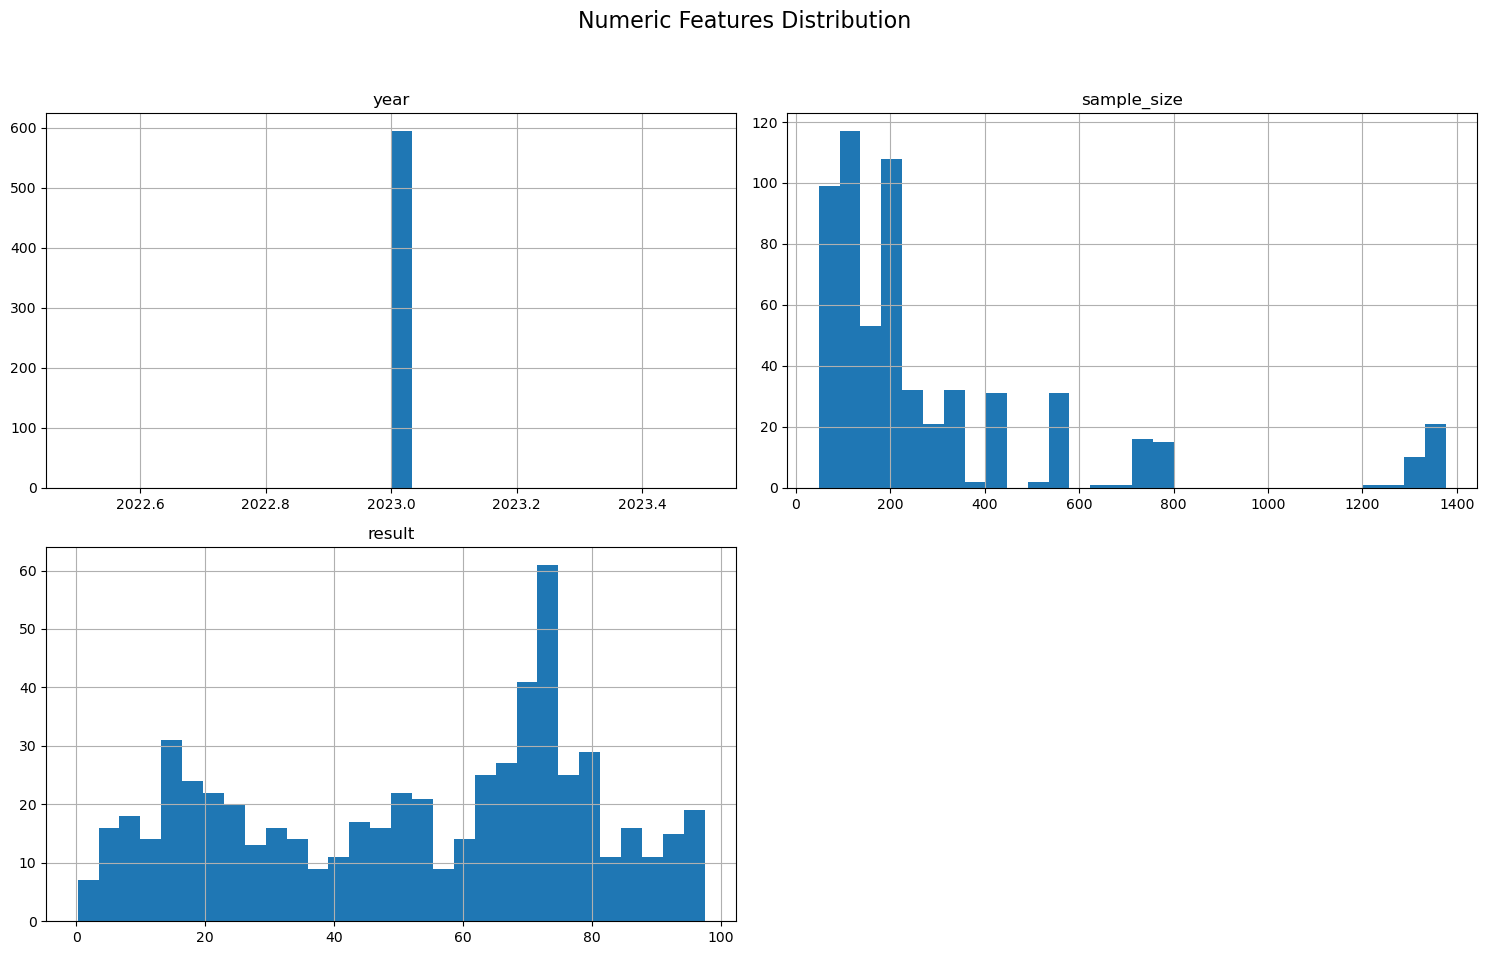

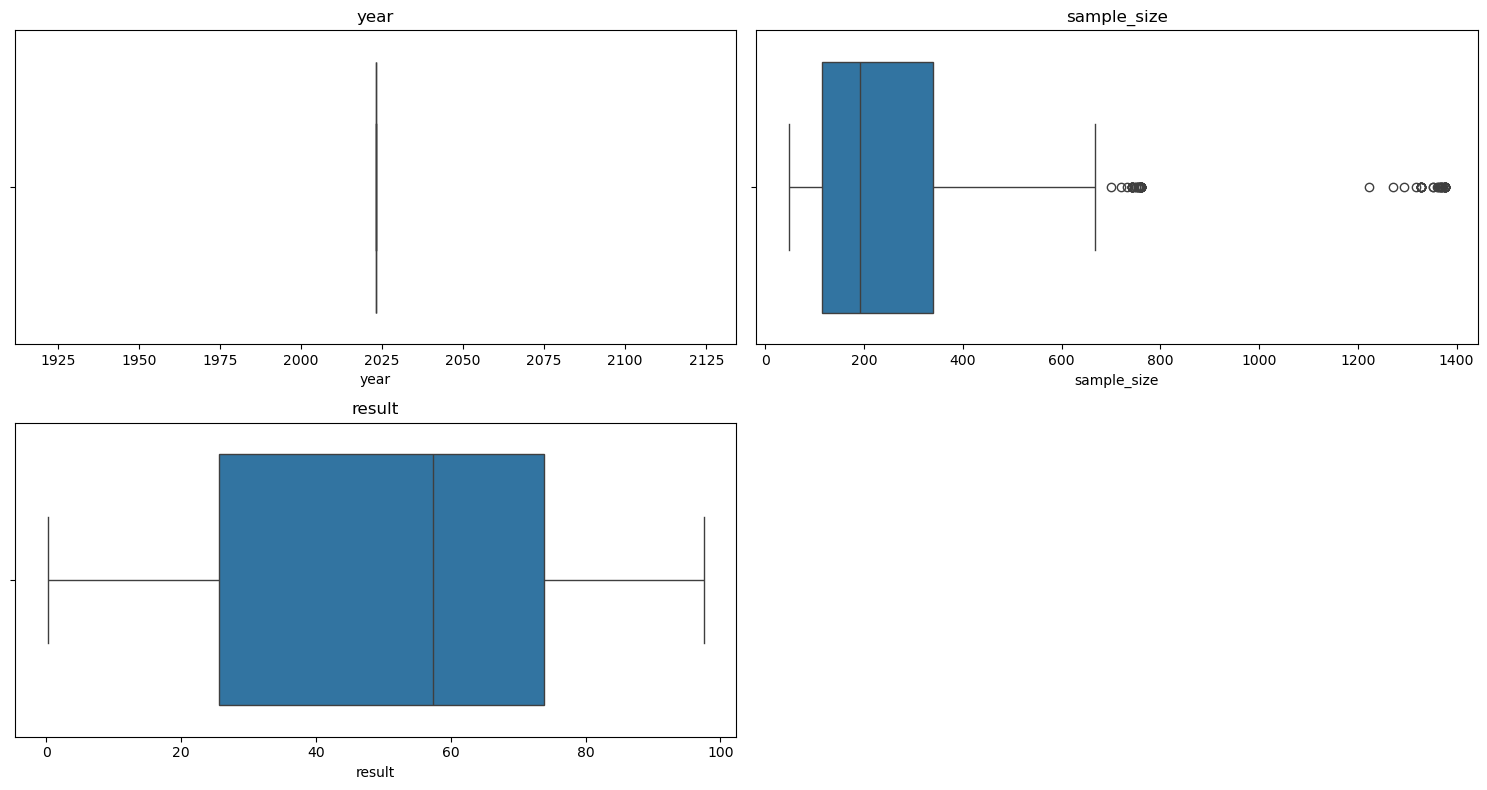

In [33]:
# Plot histograms for numeric columns to see their distributions
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Numeric Features Distribution", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Optionally, show boxplots to check for outliers
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, (len(numeric_cols)+1)//2, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


This code first selects all numeric columns (int64 and float64) and creates histograms (with 30 bins) for each to show their distributions, adding an overall title and ensuring neat spacing with `tight_layout()`. Then it creates boxplots for each numeric column arranged in a grid (2 rows) to visually highlight medians, spreads, and potential outliers, again using `tight_layout()` for clean formatting.

<h1>Correlation Analysis and Correlation Matrix</h1>

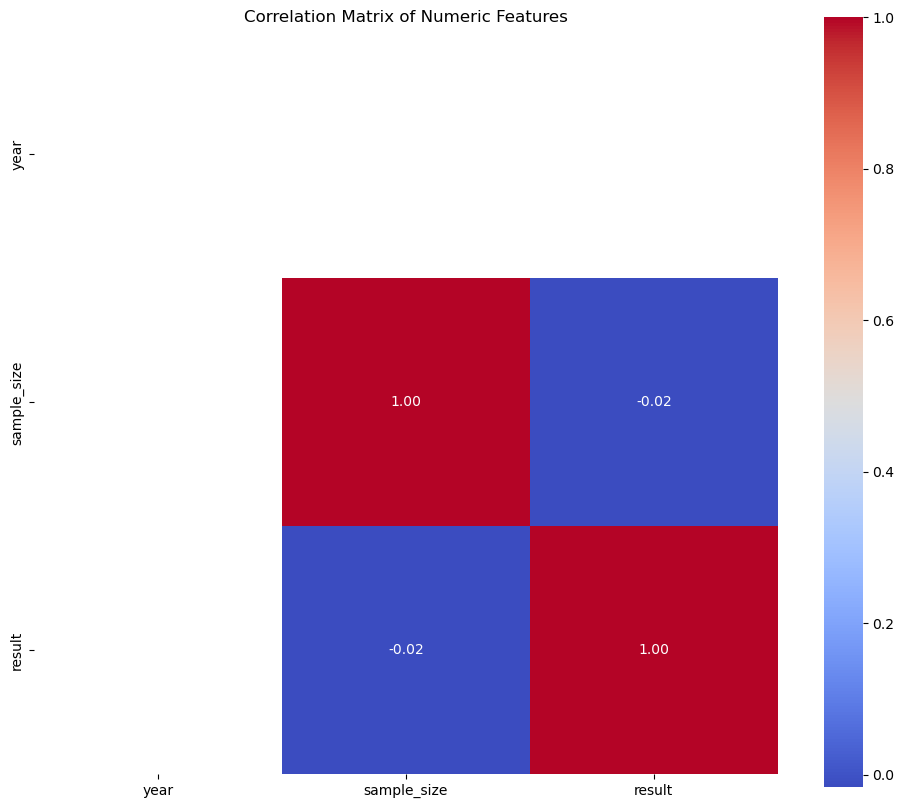

In [36]:
corr_matrix = df[numeric_cols].corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

This code first selects all numeric columns from the DataFrame and computes their pairwise Pearson correlation, creating a correlation matrix. It then creates a 12×8 inch figure and uses Seaborn's heatmap function to visually represent the correlation matrix, with each cell annotated with the corresponding correlation value (formatted to two decimals) and colored using the "YlGnBu" colormap. Finally, it sets an overall title, adjusts the layout for proper spacing, and displays the plot.

<h1>Top 10 categories for Each Categorical Column</h1>

In [39]:
categorical_columns = df.select_dtypes(include='object').columns


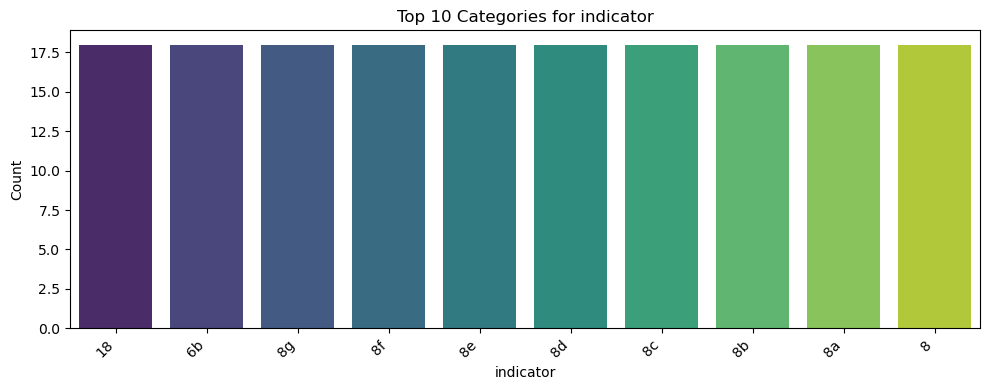

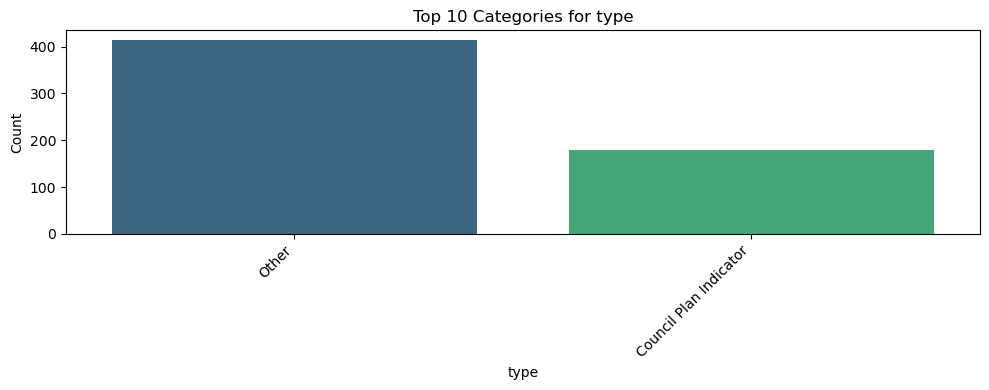

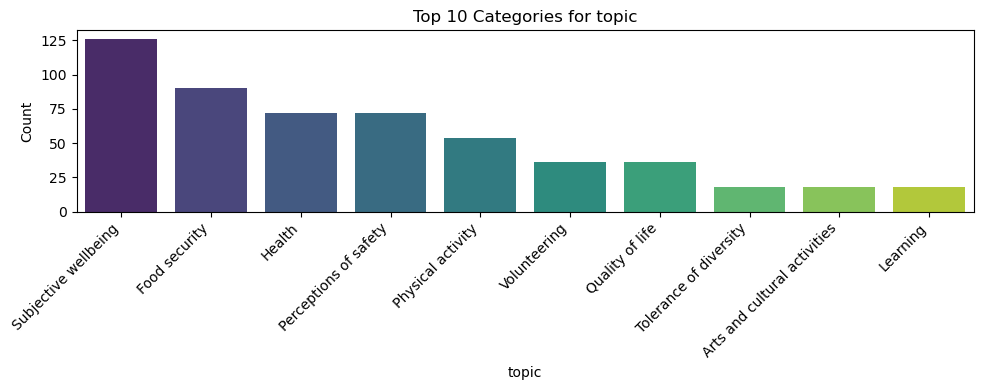

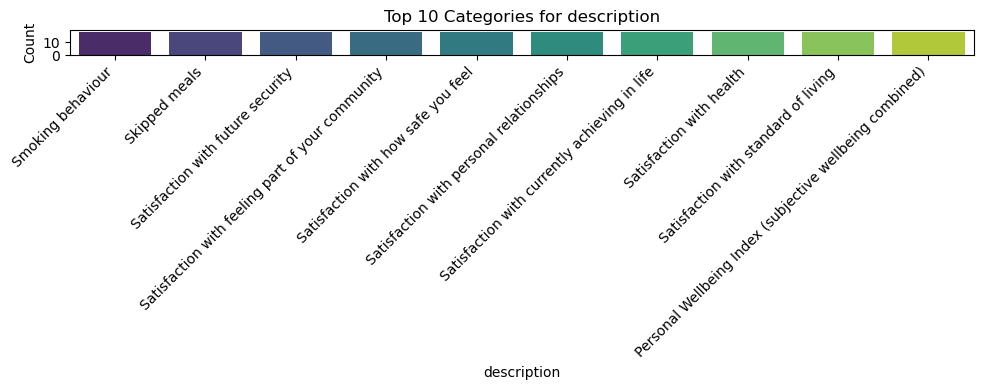

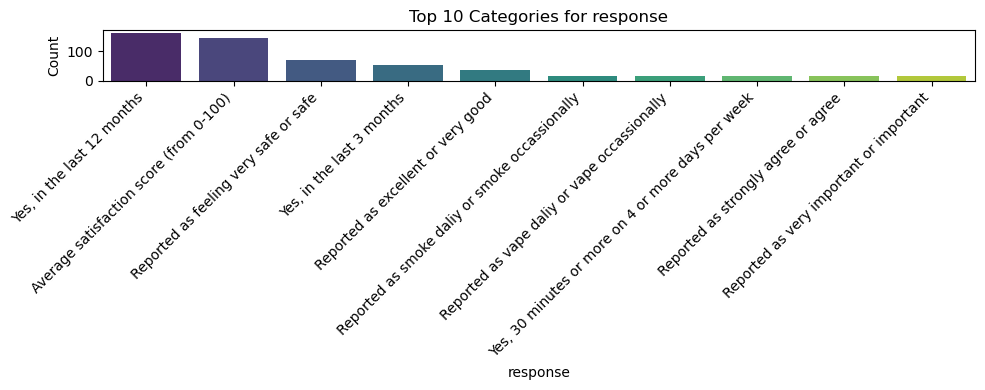

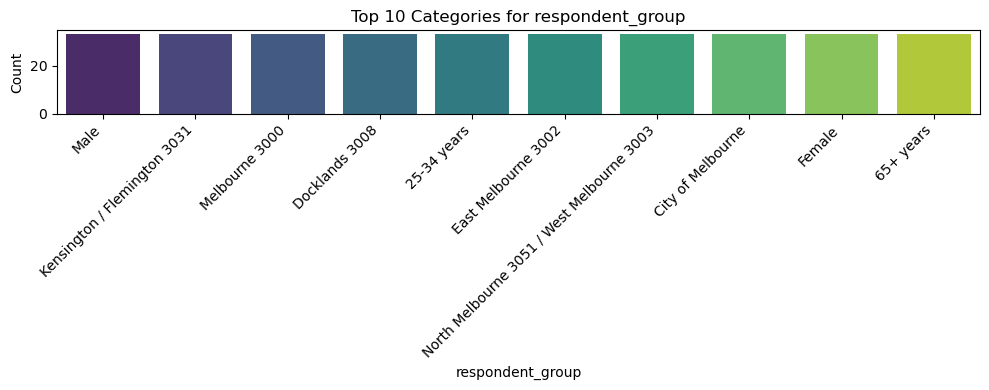

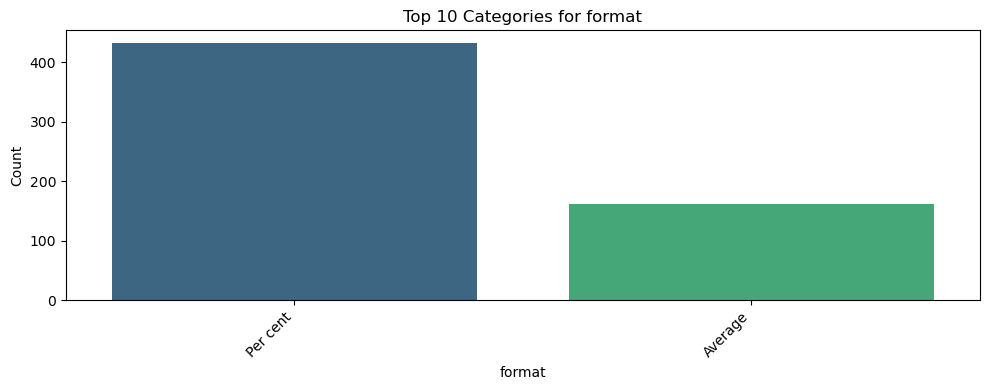

In [40]:
for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    top_values = df[col].value_counts().nlargest(10)
    order = top_values.index
    # Use hue, but then remove the legend to avoid clutter.
    ax = sns.barplot(x=top_values.index, y=top_values.values, hue=top_values.index, order=order, palette="viridis")
    plt.title(f"Top 10 Categories for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    plt.tight_layout()
    plt.show()


This code iterates over every categorical column in your dataset to generate individual bar plots for the top 10 most frequent values in each column. For each column, it first creates a new figure with dimensions of 10 by 4 inches, then computes the frequency of each unique value using `value_counts()` and selects the 10 most common values with `nlargest(10)`, preserving their order. A bar plot is generated using Seaborn’s `barplot` function, where the x-axis displays the category names and the y-axis displays their corresponding counts; the `hue` parameter is also set to the same category values to apply the "viridis" color palette, although this results in a redundant legend that is subsequently removed if present. The plot is enhanced with a dynamic title that includes the column name, appropriate x and y labels, and the x-axis labels are rotated by 45 degrees and right-aligned for better readability. Finally, `plt.tight_layout()` ensures that all elements fit neatly within the figure before the plot is rendered with `plt.show()`.

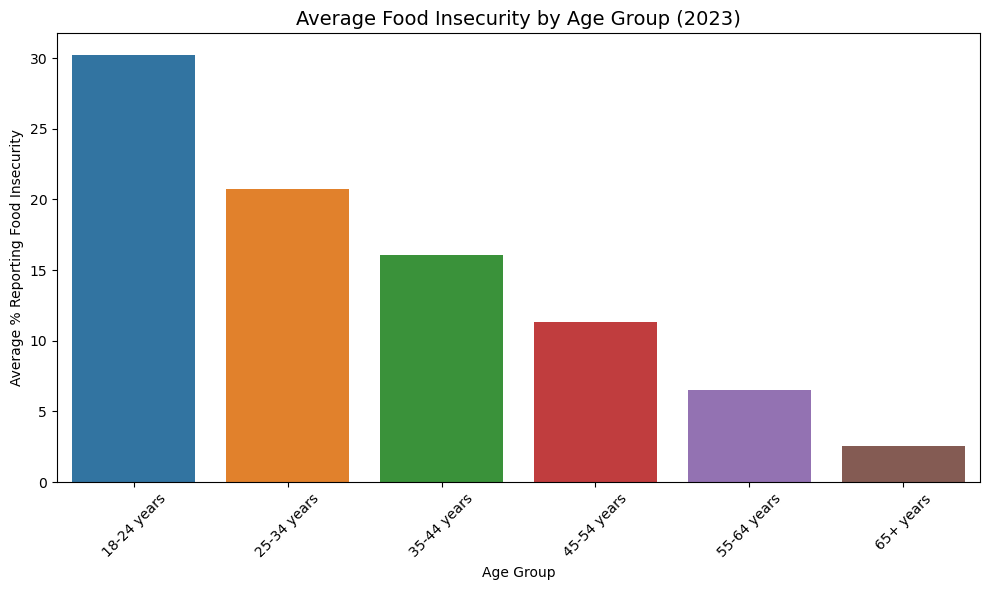

In [42]:
food_security = df[
    (df['topic'] == 'Food security') &
    (df['respondent_group'].str.contains('years'))
].copy()

# Clean result column (convert from string to float if needed)
food_security['result'] = pd.to_numeric(food_security['result'], errors='coerce')

# Group by age group and calculate mean result
age_group_data = food_security.groupby('respondent_group')['result'].mean().reset_index()

# Sort by age group (optional: if age groups are in correct order)
age_group_data = age_group_data.sort_values(by='respondent_group')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=age_group_data, x='respondent_group', y='result', hue='respondent_group', legend=False)
plt.title("Average Food Insecurity by Age Group (2023)", fontsize=14)
plt.xlabel("Age Group")
plt.ylabel("Average % Reporting Food Insecurity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In this code, I filtered the dataset to focus on responses related to "Food security" for different age groups. I converted the response values to numeric format to ensure accurate calculations. Then, I grouped the data by age group and calculated the average percentage of respondents reporting food insecurity within each group. This helps identify which age groups are most affected. The results are visualized using a Seaborn bar plot, allowing for a clear comparison of food insecurity levels across age demographics in the 2023 survey. The food insecurity have data like "worried food would run out", "Skipped Meals", and "Ran out of food". This insight helps the local government and policymakers to identify vulnerable age groups with high food insecurity rates. As per the bar graph we can see that the food insecurity is highest among younger age groups, particularly those aged 18–24, with nearly 30% reporting difficulties accessing food. This percentage declines steadily with age, dropping to just 3% among those aged 65 and over. The trend suggests that younger people face more financial instability or limited support systems compared to older adults. Older age groups may benefit from stable income, pensions, or established housing, which reduce food-related stress. This insight highlights the need for targeted food support and affordability programs focused on youth and young adults to reduce vulnerability and improve wellbeing.


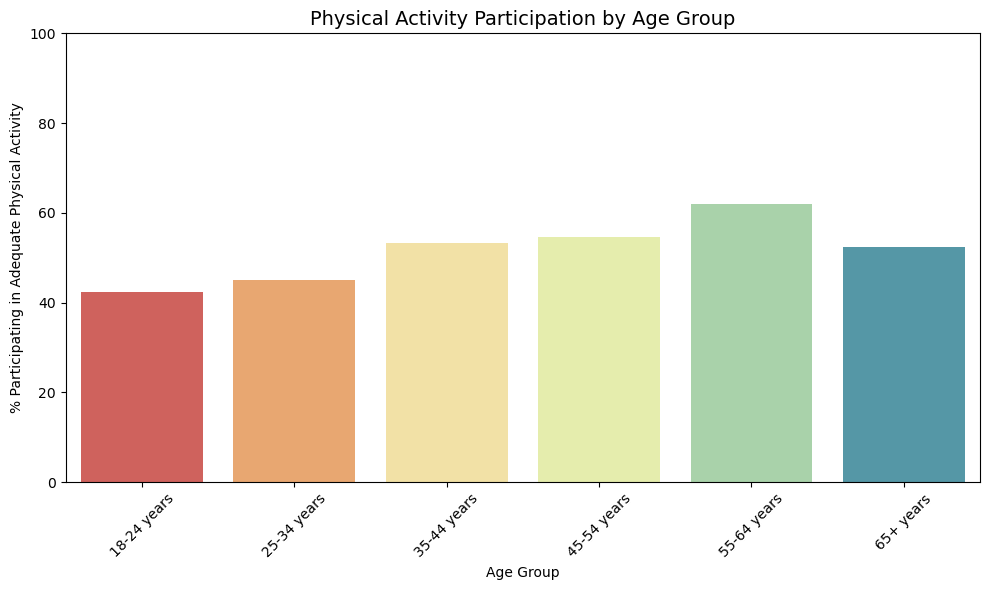

In [44]:
#Filter data related to physical activity
physical_df = df[
    (df['topic'].str.contains('Physical activity', case=False, na=False)) &
    (df['description'].str.contains('Participate in adequate physical activity', case=False, na=False)) &
    (df['respondent_group'].str.contains('years', na=False))
].copy()

#Convert result column to numeric
physical_df['result'] = pd.to_numeric(physical_df['result'], errors='coerce')

#Clean and format age group
physical_df['age_group'] = physical_df['respondent_group']

# Step 4: Group by age group and get average physical activity %
age_summary = physical_df.groupby('age_group')['result'].mean().reset_index()
age_summary = age_summary.sort_values(by='age_group')  # Optional: alphabetical or age order

#Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=age_summary, x='age_group', y='result', hue= 'age_group', palette='Spectral')
plt.title("Physical Activity Participation by Age Group", fontsize=14)
plt.xlabel("Age Group")
plt.ylabel("% Participating in Adequate Physical Activity")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In the above code, the analysis looks at how many people in each age group are getting enough physical activity. I filtered the dataset to only include answers about physical activity and kept only age-based responses. I then cleaned the data and calculated the average result for each age group. Finally, I used a bar chart to show the percentage of people in each group who are meeting physical activity guidelines. This makes it easy to compare activity levels across different ages.

The chart shows that physical activity participation varies across age groups, with the 55–64 age group being the most active (over 60%) and the 18–24 group the least active (around 42%). Participation generally increases with age, peaking in middle age before slightly declining in older adults. This trend suggests that younger adults may face more barriers to staying active, such as work, study, or lifestyle factors. The insight is valuable as it identifies where to focus physical health campaigns or support programs. Encouraging activity in younger age groups could help improve long-term health outcomes and reduce future health risks.


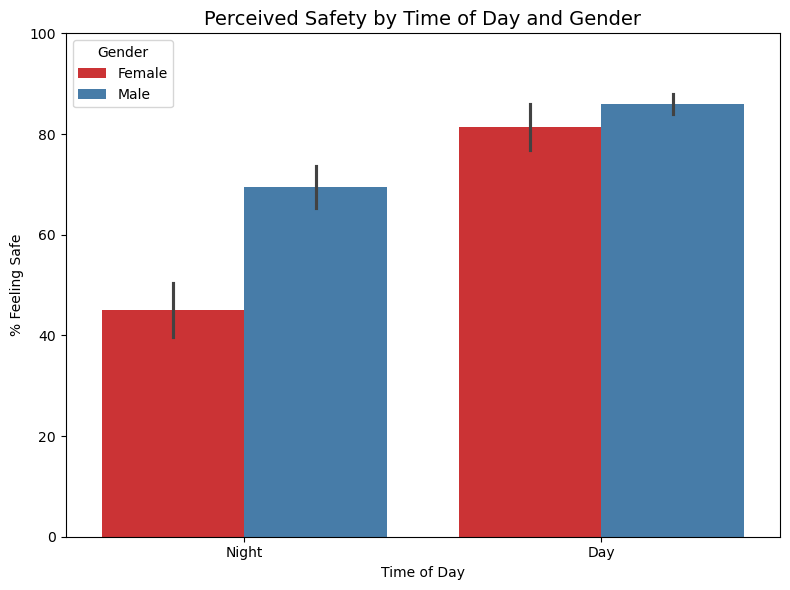

In [45]:
safety_df = df[
    (df['description'].str.contains('feel safe', case=False, na=False)) &
    (df['respondent_group'].notna())
].copy()

#converting into numeric values
safety_df['result'] = pd.to_numeric(safety_df['result'], errors='coerce')

#Extracting gender from the respondent group
def extract_gender(text):
    if isinstance(text, str):
        text = text.lower()
        if "female" in text:
            return "Female"
        elif "male" in text:
            return "Male"
        elif "non-binary" in text:
            return "Non-binary"
    return None

safety_df['gender'] = safety_df['respondent_group'].apply(extract_gender)

#Extract time of day from description
safety_df['time'] = safety_df['description'].apply(
    lambda x: "Day" if "during the day" in x.lower()
    else "Night" if "at night" in x.lower()
    else None
)

#Drop rows which doesnt have gender or time
safety_df = safety_df.dropna(subset=['gender', 'time', 'result'])

#Plotting 
plt.figure(figsize=(8, 6))
sns.barplot(data=safety_df, x='time', y='result', hue='gender', errorbar='sd', palette='Set1')
plt.title("Perceived Safety by Time of Day and Gender", fontsize=14)
plt.ylabel("% Feeling Safe")
plt.xlabel("Time of Day")
plt.ylim(0, 100)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


This code analyzes how safe people feel during the day and night based on their gender. It filters the data for safety-related responses, extracts gender and time information, and cleans missing values. Then, it plots a bar chart showing differences in perceived safety between males, females, and non-binary individuals.

This chart shows how perceptions of safety vary by gender and time of day. Overall, people feel significantly safer during the day than at night. Men consistently report feeling safer than women in both time periods. At night, the gap is especially wide—only about 45% of women feel safe compared to around 70% of men. During the day, safety perceptions rise for both genders, but men still feel slightly safer.

This insight is important because it highlights a gender-based variation in public safety perception, especially after dark. It suggests a need for targeted community safety improvements, such as better lighting, surveillance, or patrol presence in areas where women report feeling unsafe. 

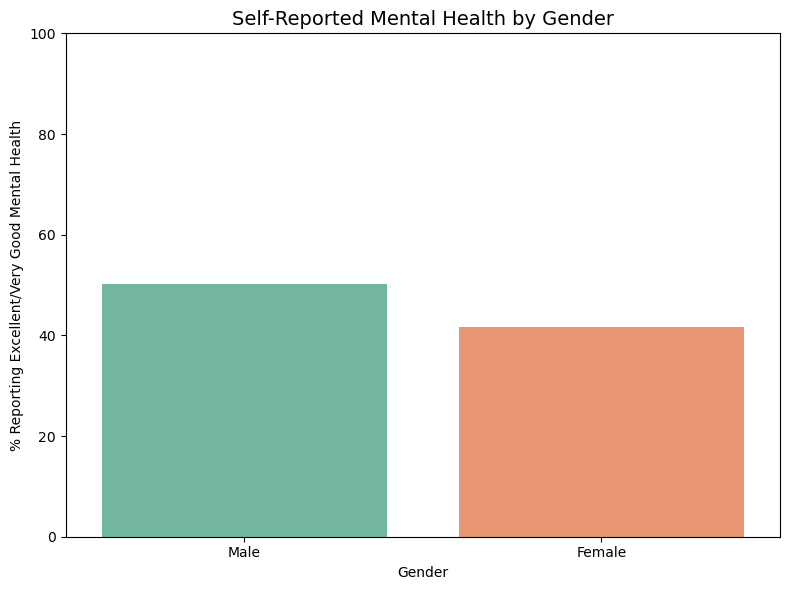

In [46]:
#Filter for self-reported mental health records from the dataset
mh_df = df[df['description'].str.contains('Self reported mental health', case=False, na=False)].copy()

#Convert result column to numeric
mh_df['result'] = pd.to_numeric(mh_df['result'], errors='coerce')

#Extract gender from respondent_group
def extract_gender(text):
    if isinstance(text, str):
        text = text.lower()
        if 'female' in text:
            return 'Female'
        elif 'male' in text:
            return 'Male'
        elif 'non-binary' in text:
            return 'Non-binary'
    return None

mh_df['gender'] = mh_df['respondent_group'].apply(extract_gender)

#Droping all the missing values
mh_df = mh_df.dropna(subset=['gender', 'result'])

#plot
plt.figure(figsize=(8, 6))
sns.barplot(data=mh_df, x='gender', y='result', errorbar='sd', hue='gender', palette='Set2', legend=False)
plt.title("Self-Reported Mental Health by Gender", fontsize=14)
plt.ylabel("% Reporting Excellent/Very Good Mental Health")
plt.xlabel("Gender")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

This code looks at how people of different genders rate their own mental health. It filters the data for self-reported mental health responses, converts the results to numbers, and pulls out gender information. After removing missing values, it creates a bar chart to show the percentage of each gender group that reports excellent or very good mental health.

This chart shows self-reported mental health ratings by gender, specifically the percentage of individuals who rated their mental health as excellent or very good. The results indicate that males report better mental health than females, with a noticeable gap between the two groups. This suggests a gender-based difference in mental health experiences. The insight is useful because it highlights potential mental health variations that may need to be addressed through gender-sensitive programs or services. It also reinforces the importance of creating inclusive mental health support systems that consider the different challenges faced by men and women in the community.

indicator
Perceived Safety    36
Mental Health        9
Food Security        9
Name: count, dtype: int64


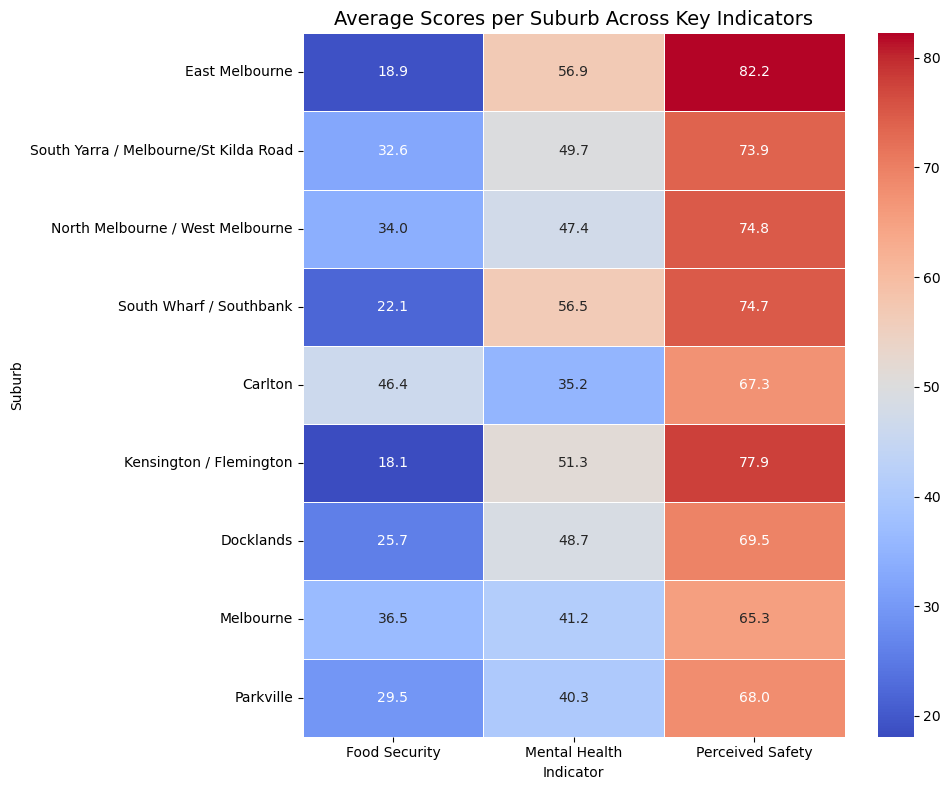

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

#Filter relevant rows (Three indicators are chose "Food", "mental health" and "Safety")
topics_of_interest = ['food', 'mental health', 'feel safe']

df_filtered = df[
    df['topic'].str.contains('|'.join(topics_of_interest), case=False, na=False) &
    df['respondent_group'].str.contains(r'\d{4}', na=False)
].copy()

#filtering relevent rows which has the three selected inidcators
df_filtered = df[
    df['description'].str.contains('food|mental health|feel safe', case=False, na=False) &
    df['respondent_group'].str.contains(r'\d{4}', na=False)
].copy()

# Extract suburb name from respondent_group and removing the postcode
df_filtered['suburb'] = df_filtered['respondent_group'].apply(
    lambda x: re.sub(r'\s*\d{4}', '', x).strip() if isinstance(x, str) else None
)


#Standardize topic names
def standardize_topic(text):
    text = text.lower()
    if "food" in text and "insecurity" in text:
        return "Food Security"
    elif "mental health" in text:
        return "Mental Health"
    elif "feel safe" in text:
        return "Perceived Safety"
    else:
        return None


df_filtered['indicator'] = df_filtered['description'].apply(standardize_topic)

print(df_filtered['indicator'].value_counts())

# Clean and pivot
df_filtered['result'] = pd.to_numeric(df_filtered['result'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['suburb', 'indicator', 'result'])

heatmap_data = df_filtered.groupby(['suburb', 'indicator'])['result'].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index='suburb', columns='indicator', values='result')
heatmap_pivot = heatmap_pivot.loc[heatmap_pivot.mean(axis=1).sort_values(ascending=False).index]

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5)
plt.title("Average Scores per Suburb Across Key Indicators", fontsize=14)
plt.xlabel("Indicator")
plt.ylabel("Suburb")
plt.tight_layout()
plt.show()



This code compares how different suburbs score across three key indicators: food security, mental health, and perceived safety. It filters the dataset to include only those topics and extracts suburb names by removing postcodes from the respondent information. Then, it standardizes topic names, converts the results to numbers, and calculates the average score for each indicator in each suburb. Finally, it creates a heatmap to clearly show which suburbs are doing better or worse on these indicators, helping identify areas that may need attention.

This insight helps identify which suburbs may need targeted support in specific areas. It enables local governments to design suburb-specific policies for example, focusing food programs in Carlton and mental health services in Melbourne. The visual format also makes it easy to compare and prioritise areas based on multiple indicators. This heatmap shows the average scores for food security, mental health, and perceived safety across different Melbourne suburbs. Suburbs like East Melbourne and Kensington / Flemington have high perceived safety and mental health scores but differ in food security levels. In contrast, Carlton has the highest food insecurity and one of the lowest mental health scores. The variation across suburbs highlights clear spatial inequalities in community wellbeing.

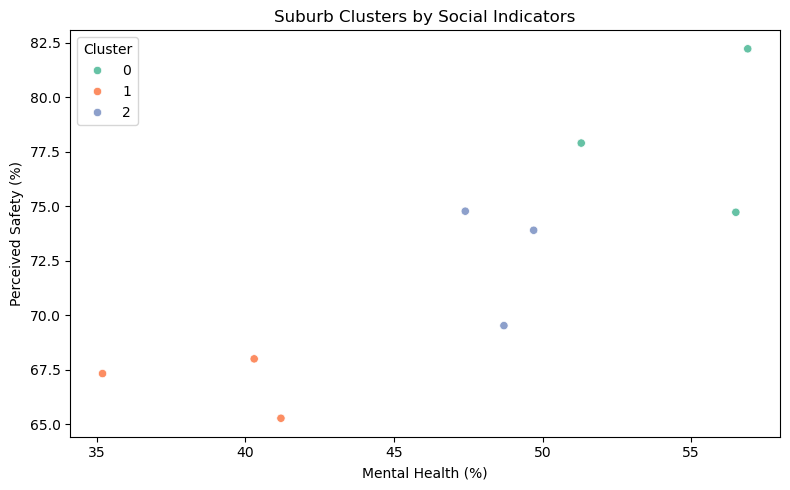

In [48]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Pivot to suburb-wise indicator matrix as `heatmap_pivot`
df_cluster = heatmap_pivot.dropna()

# Features scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

#Applying KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

#Visualize
import seaborn as sns
import matplotlib.pyplot as plt

#Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_cluster, x='Mental Health', y='Perceived Safety', hue='Cluster', palette='Set2')
plt.title("Suburb Clusters by Social Indicators")
plt.xlabel("Mental Health (%)")
plt.ylabel("Perceived Safety (%)")
plt.tight_layout()
plt.show()


This code groups suburbs into three clusters based on their average scores for key social indicators. It standardizes the data, applies KMeans clustering, and then plots the suburbs using their Mental Health and Perceived Safety scores to visualize how the clusters differ.

Using K-Means clustering on the suburb-level averages of food security, mental health, and perceived safety, we grouped Melbourne suburbs into three distinct clusters based on their social indicator profiles. This clustering approach helps identify suburbs that share similar levels of community well-being, making it easier to prioritize interventions. For instance, one cluster may represent well-performing suburbs with high mental health and safety, while another may consist of more vulnerable areas with lower scores across multiple indicators. By visualizing these clusters, we gain a clear, interpretable segmentation that supports targeted policy decisions and efficient allocation of community resources, especially for suburbs with consistent social challenges.

In [50]:
from sklearn.linear_model import LinearRegression

# Drop NA and build a small dataset
df_ml = heatmap_pivot.dropna()

X = df_ml[['Food Security', 'Perceived Safety']]
y = df_ml['Mental Health']

# Fit regression model
model = LinearRegression()
model.fit(X, y)

# Print coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(X.columns, model.coef_)))


Intercept: 13.687948713276342
Coefficients: {'Food Security': -0.40744432108483075, 'Perceived Safety': 0.6295299831449418}


This code builds a simple linear regression model to predict Mental Health scores based on Food Security and Perceived Safety. It trains the model on the suburb-level data and prints the intercept and the influence (coefficients) of each predictor on mental health outcomes.
A linear regression model was used to predict average mental health scores across Melbourne suburbs based on two key social indicators: food security and perceived safety. The results showed that perceived safety has a strong positive relationship with mental health, with a coefficient of 0.63, indicating that suburbs where residents feel safer tend to report better mental health outcomes. Interestingly, food security showed a slightly negative coefficient (-0.41), which may be due to the limited sample size or overlapping effects with other variables. The model’s intercept was 13.69, forming the baseline from which the two predictors influence the outcome. This analysis quantifies the contribution of each factor and suggests that efforts to improve community safety perceptions may have a more direct and measurable impact on mental health than food access alone, offering a data-driven basis for targeted interventions in urban planning and public health.

In [52]:
from sklearn.linear_model import LinearRegression

# Prepare data
df_reg = heatmap_pivot.dropna()
X = df_reg[['Food Security', 'Perceived Safety']]
y = df_reg['Mental Health']

# Fit regression model
model = LinearRegression()
model.fit(X, y)

# Output results
print("\n🔍 Linear Regression to Predict Mental Health")
print("Intercept:", round(model.intercept_, 2))
print("Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"  {feature}: {round(coef, 2)}")

# Optional: Predict for each suburb
df_reg['Predicted Mental Health'] = model.predict(X).round(1)

# View comparison
print("\nComparison of Actual vs Predicted Mental Health:")
print(df_reg[['Mental Health', 'Predicted Mental Health']])



🔍 Linear Regression to Predict Mental Health
Intercept: 13.69
Coefficients:
  Food Security: -0.41
  Perceived Safety: 0.63

Comparison of Actual vs Predicted Mental Health:
indicator                              Mental Health  Predicted Mental Health
suburb                                                                       
East Melbourne                                  56.9                     57.8
South Yarra / Melbourne/St Kilda Road           49.7                     46.9
North Melbourne / West Melbourne                47.4                     46.9
South Wharf / Southbank                         56.5                     51.7
Carlton                                         35.2                     37.2
Kensington / Flemington                         51.3                     55.4
Docklands                                       48.7                     47.0
Melbourne                                       41.2                     39.9
Parkville                                    

In this code, a linear regression model is applied to predict the average mental health score of each suburb using two input features: food security and perceived safety. The dataset used ('heatmap_pivot') contains average indicator values for each suburb, and the model learns a mathematical relationship between these features and mental health outcomes. The model’s equation shows that perceived safety has a strong positive influence on mental health (coefficient = 0.63), while food security has a smaller, slightly negative effect (coefficient = -0.41). After training, the model is used to generate predicted mental health scores for each suburb, which are then compared against actual values. This step validates how closely the model reflects reality. The usefulness of this approach lies in its ability to quantify the relative impact of safety and food access on mental well-being and to forecast mental health outcomes for other areas if these two indicators are known. This predictive capability adds a deeper, data-driven layer to your analysis and supports more informed decision-making in community health planning.

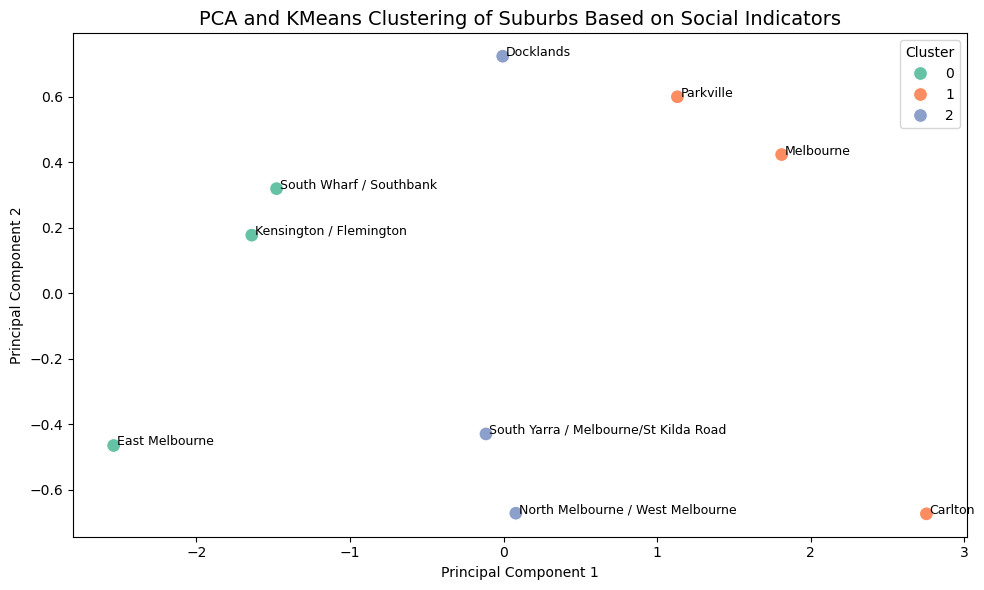

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Prepare and scale the data
df_pca = heatmap_pivot.dropna()
X = df_pca[['Food Security', 'Mental Health', 'Perceived Safety']]
X_scaled = StandardScaler().fit_transform(X)

#Apply PCA 
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

#Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_components)

#Create a dataframe for plotting
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Suburb'] = df_pca.index
pca_df['Cluster'] = clusters

#Visualize the results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=100)

#Adding suburb labels
for i in range(len(pca_df)):
    plt.text(pca_df['PC1'][i] + 0.02, pca_df['PC2'][i], pca_df['Suburb'][i], fontsize=9)

plt.title("PCA and KMeans Clustering of Suburbs Based on Social Indicators", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


I analysed Melbourne’s social indicators dataset to explore how suburbs differ in terms of food security, mental health, and perceived safety. To better understand the underlying patterns, I applied Principal Component Analysis (PCA), which helped reduce the complexity of the data by combining the three indicators into two main components. This allowed me to visualise the suburbs in a 2D space and see how they grouped based on social similarity. I then used KMeans clustering on these components to identify three distinct clusters of suburbs with shared social profiles. The results showed which suburbs had similar challenges or strengths, making it easier to recommend targeted community interventions. Instead of treating every suburb in isolation, the PCA and clustering helped highlight how some areas could benefit from shared support programs or coordinated planning strategies, based on their overall wellbeing patterns.

REFERENCES

City of Melbourne Open Data Portal: https://data.melbourne.vic.gov.au

<ul>Python Libraries:</ul>

Pandas Documentation
Seaborn Documentation
Matplotlib Documentation

REFLECTION

While working on this analysis, I improved my understanding of handling real-world survey data, especially how to clean and filter datasets for focused analysis. I also got better at using visualization tools like Seaborn to explore trends related to social well-being indicators such as food security and perceptions of safety. It was insightful to see how different groups in Melbourne experience public services and social conditions differently.

NEXT STEPS:

>>Perform advanced statistical modeling (e.g., regression or clustering) to explore deeper patterns
>>Include more years of data to identify long-term trends
>>Explore other variables like income level, transport usage, or education for richer insights
>>Create interactive dashboards using Power BI or Tableau for stakeholder presentation
>>Collaborate with local authorities to validate and extend the insights for decision-making

LIMITATIONS:

--> The dataset only covers survey responses from a single year and may not reflect long-term patterns
--> Some responses contain missing or incomplete data, which may bias results
--> Visualizations are based on self-reported perceptions, which may not represent objective conditions
--> The analysis focuses only on selected topics (food security, mental health, safety) and excludes others
--> Geographic granularity is limited to suburbs, and responses may not reflect intra-suburb diversity

RECOMMENDATIONS

--> Public Safety: Suburbs with low perceived safety (especially among women) should be prioritized for safety audits and community policing programs.
--> Food Security: Awareness and aid programs should target age groups reporting high food insecurity, particularly younger and older adults.
--> Mental Health: Increase mental health service accessibility in areas with low reported well-being.
--> Community Engagement: Encourage greater community participation to strengthen social connection, especially in suburbs showing low engagement rates.
--> Ongoing Monitoring: Continue tracking these indicators yearly and expand the dataset to include more demographic attributes for deeper analysis.

CONCLUSION:

The notebook includes:

>> Data Extraction using API, Cleaning the Data and performing Exploratory Data Analysis on the Dataset
>> Explored the data to understand and some key insights have been indentified


Some key Insights from the dataset are:

>> Average food insecurity among different age groups, this insight helps us to understand which age group is struggling from food insecurity such as skipped meals, ran out of food. This insight highlights the need for targeted food support and affordability programs focused on youth and young adults to reduce vulnerability and improve wellbeing.

>> Physical Activity Participation, the insight is valuable as it identifies where to focus physical health campaigns or support programs. Encouraging activity in younger age groups could help improve long-term health outcomes and reduce future health risks.

>> Perceptions of safety vary by gender and time of day, this insight helps us understand how many people(gender-wise) are feeling safe in the time of day. Based on this insight we can focus on the gender who are feeling not safe in a specific time of the day and provide more helpful resources for them to overcome it.

>> The project identifies key relationships, such as the positive influence of perceived safety on mental health and the negative impact of food insecurity. It further applies linear regression to model these relationships and uses PCA with KMeans clustering to group suburbs based on similar social characteristics.